# Deep Q-learning (First steps)
### 2022/06/03, AJ Zerouali


## 1 - Introduction


### a) Goals
Our objective here is to implement a deep Q-learning agent that solves some basic OpenAI Gym tasks. On the one hand, this a warmup for the implementation of actor-critic algorithms, as well as an opportunity to gain a deeper understanding of deep RL in practice (e.g. using TensorFlow with Gym).


There are several topics that we intend to cover, most of which are high-level:

- The TensorFlow API: How NN models are organized, including their instantiation, storage of weights, execution of backpropagation/SGD, interaction of the NN object with the optimizer.

- Design and implementation of a deep RL agent: The agent class, its memory, how it interacts with Gym environment.

- Coding a deep RL learning algorithm and performance assessment.

**Important:** The above is a very rough list of objectives and I should make a table of contents. I also have to flesh-out what I'm trying to learn (22/05/08 - 15:45 : I have too many disordered questions at present, even those I need to organize properly).

### b) To do

- Start by implementing a naive deep Q-learning agent.
- Once the above is done, make notes of what you've learned: DQN in general, high level overview of implementation details.
- Double DQN after that.


### References
My references for this notebook are:
* Phil Tabor's free Youtube lectures on DQN.

    Playlist: https://www.youtube.com/watch?v=4GhH3d9NsIc&list=PL-9x0_FO_lgn8hXJk5uRv1bO36xyTx00f&ab_channel=MachineLearningwithPhil,
    
    GitHub repo at: https://github.com/philtabor/Youtube-Code-Repository/tree/master/ReinforcementLearning/DeepQLearning.
    
    
* Stefan Jansen's "Machine Learning for Algorithmic Trading" book. TensorFlow is introduced in Ch. 17 - Deep learning for trading; OpenAI and DQN are discussed in Ch. 22 - Deep RL.

    Github DQN example: https://github.com/stefan-jansen/machine-learning-for-trading/blob/main/22_deep_reinforcement_learning/03_lunar_lander_deep_q_learning.ipynb
    
* Maxim Lapan's "Deep Reinforcement Learning Hands-On". Chapter 2 has a good description of the OpenAI Gym API (better than Ravichandiran's), explains the software architecture of the Environment and Space classes of this package, and briefly discusses wrappers at the end of the chapter. The deep networks are implemented with PyTorch however.

* Sudharsan Ravichandiran's "Deep Reinforcement Learning with Python". This book is very similar in terms of contents and scope to Lapan's, but uses TensorFlow 2 and Keras for the implementation of deep networks. Chapter 8 in particular gives a rather detailed primer on TensorFLow, and does a good job of including API details that are absent from all courses and tutorials I've seen previously.

* The following notes from Brunskill RL course at Stanford are useful later: https://web.stanford.edu/class/cs234/CS234Win2019/slides/lnotes6.pdf

## Contents

Fill this out. Comment on it above

### Fundamental imports

What we're importing and why. Specific references to sections.

In [1]:
# Hide deprecation warnings
import warnings
warnings.filterwarnings('ignore')

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import gym


In [2]:
%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [3]:
import tensorflow as tf
from tensorflow import keras

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:18: DeprecationWarning: Call to deprecated create function FileDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  DESCRIPTOR = _descriptor.FileDescriptor(
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:36: DeprecationWarning: Call to deprecated create function FieldDescriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _descriptor.FieldDescriptor(
C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\core\framework\tensor_shape_pb2.py:29: DeprecationWarning: Call to deprecated create function Descriptor(). Note: Create unlinked descriptors is going to go away. Please use get/find descriptors from generated code or query the descriptor_pool.
  _TENSORSHAPEPROTO_

## 2 - Naive DQN

#### Comments:

- Tabor's not giving any explanations of what, why and how. Before looking at the implementation, I'll summarize the main ideas following the lecture notes: https://web.stanford.edu/class/cs234/CS234Win2019/slides/lnotes6.pdf.

- It is also worth looking at Ravichandiran and Lapan's books and code. I need to write more on TensorFlow in another notebook and maybe compile them in a single one.


### a) Generalities on deep Q-learning

Deep Q-learning falls within the "value function approximation" topic of reinforcement learning, and is an algorithm based on temporal difference learning and nonlinear function approximation in RL. As the name suggests, we use a neural network to learn the action-value function Q. We assume here that the action space is **finite** ($|\mathcal{A}|<\infty$). The example we follow here is adapted to the Lunar Lander environment of OpenAI Gym, for which the action space is finite and the state space is continuous. To clarify the implementation, we will briefly discuss the theory behind the algorithm, the pseudocode of the algorithm, as well as certain details pertaining to the implementation in Keras/TensorFlow 2.

#### a.1 - Deriving the algorithm

First, we focus on the control problem: Computing the optimal state-action value function $Q^\ast$, and building a $\varepsilon$-greedy policy:

$$\pi(a|s)=\left\{
    \begin{array}{ll}
        1-\varepsilon, & \text{for }a=\arg\max_{a'}Q^\ast(s,a');\\
        \varepsilon, & \text{for }a\neq \arg\max_{a'}Q^\ast(s,a').
    \end{array}
   \right.$$

In practice, we will take a decreasing $\varepsilon$ during the training to get more exploration from the agent. Notice here that the TD control problem is reduced to approximating $Q$. We denote by $\widehat{Q}(s,a;\theta)$ our estimator for $Q^\ast$, with $\theta$ the parameter vector of our neural net.

Recall that the Q-learning update is given at step $k$ by:

$$Q_{k+1}(s_t,a_t)=Q_k(s_t,a_t)+\alpha\{r(s_t,a_t,s_{t+1})+\gamma\max_a Q_k(s_{t+1},a)-Q_k(s_t,a_t)\}.$$

Recall that the term $y_t=r(s_t,a_t,s_{t+1})+\gamma\max_a Q(s_{t+1},a)$ is called the **TD target**, and the term between brackets is called the temporal difference. The starting point of deep Q-learning is to parametrize the Q-function with parameters $\theta$ of a deep neural net, and using the latter to produce estimates $\widehat{Q}_\theta(s_t,a_t)$. Traditionally, this network is called the *target network*, as the loss function used for the optimization is:

$$L(\theta;s_t,s_{t+1}) = \mathbb{E}_{a_t\sim\pi}\left[(y_t-\widehat{Q}_\theta(s_t,a_t))^2\right].$$

In this setup, we minimize $L$ via minibatch stochastic gradient descent to obtain $Q^\ast\approx\widehat{Q}_{\theta^\ast}(s_t,a_t)$. Letting $N$ denote the batch size, and replacing the loss above by its batch version, our $\Delta\theta$ is given by:

$$\Delta\theta=-\frac{1}{2}\frac{\alpha}{N}\sum_{j=1}^N\nabla^\theta l(\theta;s_j,s'_j)
    =\frac{\alpha}{N}\sum_{j=1}^N\left(y_j-\widehat{Q}_\theta(s_j,a_j)\right)\nabla^\theta\widehat{Q}_\theta(s_j,a_j),$$

where $l$ is such that $L(\theta;s,s') = \frac{1}{N}\sum_j\mathbb{E}_{a\sim\pi}\left[l(\theta;s_j,s'_j)\right]$, and where the minibatch consists of quadruples $\{(s_j,a_j,r_j,s'_j)\}_{j=1}^N$ (notice the consistency of indexing). 

In practice, we relegate the computation of $\nabla^\theta L$ and $\Delta\theta$ to Keras. For practical purposes however, we design our DQN agent by additionally considering: (i) *experience replay*, and (ii) *the target network*.

**Experience replay** is the technique of storing a fixed number of past agent transitions, and reusing them during training by randomly sampling minibatches. On the one hand, this technique is data efficient, allows one to avoid oscillations and divergences in the network parameters, as well reduces the effect of sample correlations. Storing the samples requires the implementation of a *replay buffer* class, which will serve as the "memory" of the DQN agent. When performing minibatch SGD at each new training step, we will randomly draw $N$ sample transitions from this buffer.

A good practice in our case is to use a **target network** to improve the stability of the training. Although we skip this point in our first implementation below, we include it in the pseudocode for completeness. The idea is to use a different weight vector $\theta^-$ for the target $y_t=r_t+\gamma\max_a\widehat{Q}_{\theta^-}(s,a)$, and avoid using the same weights in the two terms of the temporal difference. The weights $\theta^-$ are updated with the values of $\theta$ cyclically (after say 100 training steps). When using a target network, the term $\widehat{Q}_{\theta}(s,a)$ is referred to as the *evaluation* network.


#### a.2 - Naive DQN algorithm

The pseudocode for the training of the DQN is as follows:

            Initialize replay buffer B
            Initialize eps in [0,1] and discount factor gamma
            Initialize evaluation net Q^ with random weights w
            Initialize target net Q^_tgt with weights w_ = w
            for episode m=1,..., M:
                Reset environment (observe s_1)
                for step t=1,...,T:
                    Choose random action a_t w/ prob. eps, and argmax_a Q^(s,a;w) w/ prob. 1-eps # Epsilon greedy policy
                    Observe (r_t,s_(t+1))
                    Store transition (s_t, a_t, r_t, s_(t+1)) in B
                    Sample minibatch {(s_j,a_j,r_j,s'_j)} of size N from B
                    for j=1,...,N:
                        if s_j is terminal:
                            Set y_j = r_j
                        else:
                            Set y_j = r_j + gamma*max_a Q^_tgt(s'_j,a;w_)
                    Perform SGD on L(w;w_,B) with respect to the evaluation parameters w
                    Every K steps update w_ = w.
                            
Our next step is to discuss this implementation in practice.

#### a.3 - Implementation with TensorFlow/Keras

To put things into context, let's look at the pseudocode for the training script of the DQN:

            # Initializations
            Instantiate Gym environment env
            Initialize n_episodes and N_steps_max
            Initialize hyperparameters learn_rate, eps, gamma, batch_size, mem_size...
            
            # Agent initialization
            Instantiate agent = DQN_Agent(hyperparam)
            Build agent's DQN: agent.build_dqn(network hyperparam)
            
            # Main loop
            for m=1,...,n_episodes:
            
                # Episode initializations
                Set done = False, N_steps = 0, score = 0.0
                Reset environment: s = env.reset()
                
                # Loop over episode steps
                while not done and N_steps<N_steps_max:
                    Choose action: a=agent.choose_action(s)
                    Execute actions observe new state and reward: (s_, r, done) = env.step(a)
                    Update score: score += r
                    Store transition (s,a,r,s_,done) in agent memory
                    Train DQN on random minibatch from agent memory: agent.train_dqn()
                    Update state: s = s_
                    Update step count: N_steps += 1
                    
It is clear from the above that the deep Q-network will be an attribute of the *DQN_Agent* class, and that the training of this network will be executed using a method of that class. For the experience replay, the agent will need a memory attribute, which will be implemented as a separate *Replay_Buffer* class. Let's look at more details.

**Replay_Buffer() class:**

The purpose of this class is to manage the sample transitions $(s_t, a_t, r_t, s_{t+1}, \text{done})$ obtained from the environment. There are several types of containers in Python for this type of task, but for computational efficiency, we will use separate NumPy arrays for each element of the quadruple $(s_t, a_t, r_t, s_{t+1}, \text{done})$. As such, the constructor of this class should look like:

    def __init__(self, max_size, input_dims, discrete_actions=True):
        # Memory size and counter
        self.mem_size = max_size
        self.mem_cntr = 0
               
        # Transition arrays for (s,a,s',r)
        self.memory_states = np.zeros((self.mem_size, *input_dims), dtype = np.float32)
        self.memory_actions = np.zeros(self.mem_size, \
                            dtype = np.int8 if self.discrete_actions else np.float32 )
        self.memory_next_states = np.zeros((self.mem_size, *input_dims), dtype = np.float32)
        self.memory_rewards = np.zeros(self.mem_size, dtype = np.float32)
        # If memory_next_states[t] is TERMINAL, will set memory_terminal[t]= 1, and 0 otherwise.
        self.memory_terminal = np.zeros(self.mem_size, dtype = np.int8)

The attributes *mem_size* and *mem_counter* are used when adding sample transitions from the agent's memory. Now there will be only two other methods in this class:
* **store_transitions(s,a,r,s_,done):** Which will store the quadruples $(s_t, a_t, r_t, s_{t+1}, \text{done})$ coming from the environment. In practice, we use *index=mem_counter % mem_size* for the positions in the arrays (and overwrite previously stored transitions once we collected more than *mem_size* samples).
* **sample_buffer(batch_size):** Which will be called during the training of the agent. The most efficient way of picking *batch_size* random elements from our arrays is to randomly draw a list of indices, using the **np.random.choice()** function:

            batch_indices = np.random.choice(mem_size, batch_size, replace = False)
    Passing this list to the states/actions/rewards/dones arrays of the Replay_Buffer then returns the desired arrays. (Note: This is really a neat feature of NumPy).

**DQN_Agent() class:**

Regarding the attributes of the agent, first we obviously have all the learning hyperparameters: the learning rate $\alpha$, the discount factor $\gamma$, the batch size for network SGD, a filename for storing trained network parameters, $\varepsilon$ for the exploration policy, as well as coefficients for the decrease of $\varepsilon$. Next, we need attributes for the dimensionality of the state space (comes from Gym), as well as the number of possible actions. The two remaining attributes that will interact with the environment are the **replay buffer** for memory and the **deep q-network**. The constructor looks like this:

        def __init__(self, input_dims, discrete_actions, n_actions,  \
            learn_rate, gamma, epsilon, batch_size, mem_size = 1000000, \
            epsilon_dec = 1e-3, epsilon_min =0.01, \
            dqn_fname = 'dqn_model.h5'):                                             

            # State space dimensionality
            self.input_dims = input_dims

            # Deep RL hyperparameters
            self.gamma = gamma
            self.epsilon = epsilon
            self.epsilon_min = epsilon_min
            self.epsilon_dec = epsilon_dec
            self.batch_size = batch_size
            self.learn_rate = learn_rate

            # Init. DQN (build model with method below)
            self.q_network = build_network(network_parameters)
            self.dqn_fname =  dqn_fname

            # Replay buffer. Signature: Replay_Buffer(max_size, input_dims, discrete_actions)
            self.mem_size = mem_size
            self.memory_buffer = Replay_Buffer(self.mem_size, self.input_dims, self.discrete_actions)

To implement our DQN we will use the *Sequential* class of tf.keras.models. We use two fully connected layers with ReLU activations, and a linear output layer with number of units equal to the cardinality of the action space. In this implementation, the input is a minibatch of states $\mathcal{S}=\{s_1,\cdots,s_N\}$, while the output of the network is an array $[Q(s_j,a_1),\cdots,Q(s_j,a_n)]^N_{j=1}$ (here $n=|\mathcal{A}|$).

Now, here are the methods implemented in this agent class:

* **Environment interaction**: In this part we have 2 methods. First, *choose_action(state)* is the one that takes as argument the current state/observation the Gym environment, and implements the $\varepsilon$-greedy policy used for training. Concretely, it is written as follows:

            def choose_action(self, observation):
                if np.random.uniform(0,1) < self.epsilon:
                    action = np.random.choice(self.action_space)
                else:
                    state = np.array([observation])
                    actions = self.q_network.predict(state)
                    action = np.argmax(actions)
                return action
    As seen in the pseudocode of the "main", once *choose_action* is called, one collects the next reward and state by executing:
    
            reward, next_state, done, info = env.step(action)
            
    The second method for environment interaction stores the transition into the agent's replay buffer by calling the *store_transition(s, a, r, s_, done)* method of *ReplayBuffer()*.
    
* **Q-network management**: Here we'll have one method for **building** the network (*build_dqn()*) and one to **train** the network (*train_dqn()*). We'll discuss the training a little more below, since it's the crux of the program. Concerning *build_dqn()*, Tabor writes a function outside of the agent class which is called by the constructor. I took a different approach where the constructor just assigns the string "EMPTY" when instantiating the agent.

* **Saving/loading DQN model:** These methods act on the *q_network* attribute of the agent. To save a trained model we'll use the **keras.models.Sequential.save("model_name.h5")**, and to load a model we'll use **keras.models.load("model_name.h5")**.

With these preliminaries in hand, we can finally discuss how to train our network. The following code is contained in the ***DQN_Agent.train_dqn()*** method:

            # Get minibatch of samples
            states, actions, next_states, rewards, dones = self.memory_buffer.sample_buffer(self.batch_size)
            
            # Init. Q(s,a), Q(s', a'), Q*(s,a)            
            q_eval = self.q_network.predict(states)
            q_next = self.q_network.predict(next_states)
            q_target = np.copy(q_eval)
            
            # Ones vector for "dones"
            done_ones = np.ones(shape = dones.shape, dtype=np.int8)
            
            # Iterable for minibatch
            batch_index = np.arange(self.batch_size, dtype=np.int32)
            
            ##### Q-learning update #####
            q_target[batch_index, actions] = rewards + self.gamma*np.max(q_next, axis = 1)*(done_ones - dones)
            
            ##### Train network #####
            self.q_network.train_on_batch(states, q_target)
            
            # Update epsilon for policy
            if self.epsilon_min < self.epsilon:
                self.epsilon -= self.epsilon_dec
            else:
                self.epsilon = self.epsilon_min

Let's note a couple of things here:
* This code is executed once we have collected enough samples for one minibatch. When we have less than *batch_size* samples in the replay buffer we just exit the *dqn_train* function.
* The "done" Boolean returned by *env.step()* is converted to 0 or 1 to simplify the Q-learning update. This takes care of the condition on *s_j* terminal towards the end of the DQN algorithm pseudocode, and explains the presence of the *done_ones* array above.
* The line:
            q_target[batch_index, actions] = rewards + self.gamma*np.max(q_next, axis = 1)*(done_ones - dones)
    is a condensed version of the following loop of the DQN pseudocode:
    
            for j=1,...,N:
                if s_j is terminal:
                    Set y_j = r_j
                else:
                    Set y_j = r_j + gamma*max_a Q^_tgt(s'_j,a;w_)
    
    It uses the main functionalities of NumPy for optimality, and requires some unpacking. First, note that *batch_index* is just the iterable for the loop over the minibatch (we could've taken the list [0,..., *batch_size*-1] instead of an array). Secondly, for each element $\{(s_j,a_j,r_j,s'_j)\}$ of the minibatch
    
* **(Correct this later)** Since we are performing batch SGD, we call the ***keras.models.Sequential.train_on_batch(x,y)*** method, where *x* is our minibatch of states, and where *y* is our Q-target. Here, the array *q_target[batch_index,actions]* actually represents $y=r+\gamma\max_a\widehat{Q}_{\theta}(s,a)$ previously discussed **(t'es sûr de ça?)**, and the *states* array is the input minibatch for the computation of $\left[\widehat{Q}_{\theta}(s,a_i)\right]_{i=1}^{|\mathcal A|}$.

**To do:**
- Explain TD update

**Questions:**
* How do you choose the step size $\alpha$? Is it the same as the learning rate used with Keras?
* What are the schemes for reducing the $\varepsilon$? What are the general practices?


### b) Replay buffer

This is heavily inspired by Phil Tabor's video of DQN in TF2. GitHub link: https://github.com/philtabor/Youtube-Code-Repository/blob/master/ReinforcementLearning/DeepQLearning/simple_dqn_tf2.py.


In [4]:
class Replay_Buffer():
    """
        Replay Buffer class for DQN Agent. Instantiated as an attribute of DQN_Agent class.
        Manages the transitions arrays, has one method to store the transitions,
        one method to sample a minibatch of transitions.
        Attributes: 
            mem_size: Maximal size of memory (no. of (s,a,s',r) transitions); 
            mem_cntr: No. of transitions added.
            Self explanatory (np.arrays):
            memory_states, memory_actions, memory_next_states, memory_rewards, memory_terminal
        Methods:
            store_transitions
            sample_buffer
            
    """
    def __init__(self, max_size, input_dims, discrete_actions=True):
        """
            
        INPUT: - max_size: int for max no. of transition samples
               - input_dims: int for array shape of observations
               - discrete_actions: Bool descibing action space
        
        """
        
        # Memory size and counter
        self.mem_size = max_size
        self.mem_cntr = 0
        
        # Discrete actions boolean
        self.discrete_actions = discrete_actions
                
        # Transition arrays for (s,a,s',r)
        self.memory_states = np.zeros((self.mem_size, *input_dims), dtype = np.float32)
        self.memory_actions = np.zeros(self.mem_size, \
                            dtype = np.int8 if self.discrete_actions else np.float32 )
        self.memory_next_states = np.zeros((self.mem_size, *input_dims), dtype = np.float32)
        self.memory_rewards = np.zeros(self.mem_size, dtype = np.float32)
        # If memory_next_states[t] is TERMINAL, will set memory_terminal[t]= 1, and 0 otherwise.
        # Note: Different from Tabor's implementation.
        self.memory_terminal = np.zeros(self.mem_size, dtype = np.int8)
        
    def store_transition(self, state, action, new_state, reward, done):
        """
         Method for storing transitions (s, a, s', r) in the Replay_Buffer.
         INPUT: state, action, new_state, reward = (s, a, s', r)
                done: Boolean for s' terminal
         NOTE: Using tricks from P. Tabor's implementation
        """
        # Current transition index, over-write from first position when memory is full
        ind = self.mem_cntr % self.mem_size
        
        # Add new transition
        self.memory_states[ind] = state
        self.memory_actions[ind] = action
        self.memory_next_states[ind] = new_state
        self.memory_rewards[ind] = reward
        self.memory_terminal[ind] = int(done) # P. Tabor uses (1-int(done)) here
                                                # WARNING: Might be multiplying by this number somewhere
        
        # Update counter
        self.mem_cntr += 1
        
    def sample_buffer(self, batch_size):
        """
        Method for random sampling of a memory minibatch
        INPUT: batch_size
        OUTPUT: sample_state, sample_action, sample_new_state, sample_reward, sample_terminal
                NumPy arrays of transitions of size specified by input
        """
        
        # Choose random indices 
        max_mem = min(self.mem_size, self.mem_cntr)
        batch_indices = np.random.choice(max_mem, batch_size, replace=False)
        
        # Get random minibatch
        sample_state = self.memory_states[batch_indices]
        sample_action = self.memory_actions[batch_indices]
        sample_new_state = self.memory_next_states[batch_indices]
        sample_reward = self.memory_rewards[batch_indices]
        sample_terminal = self.memory_terminal[batch_indices]
        
        return sample_state, sample_action, sample_new_state, sample_reward, sample_terminal


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


### c) DQN Agent 


In [5]:
class DQN_Agent():
    """
        Deep Q-network agent class.
        Attributes:
            * RL hyperparameters: learn_rate, gamma, batch_size
                epsilon-greedy policy: epsilon, epsilon_dec, epsilon_min
            * Memory buffer: mem_size, memory_buffer
            * State/action space: input_dims, action_space, discrete_actions
            * Deep network: q_network, dqn_fname
        
        Methods:
            * Constructor
            * Memory management: store_transition
            * Environment interaction: choose_action
            * Deep network management: build_DQN, train_dqn, save_dqn, load_dqn
    """
    
    # Constructor
                # Environment dimensions and action space params
    def __init__(self, input_dims, discrete_actions, n_actions,  \
                 # RL hyperparameters
                 learn_rate, gamma, epsilon, batch_size, mem_size = 1000000, \
                 # Decrement and lower bound for eps-greedy
                 epsilon_dec = 1e-3, epsilon_min =0.01, \
                 # Filename model for saving
                 dqn_fname = 'dqn_model.h5'):
        
        """
            INPUT: learn_rate, gamma, epsilon, batch_size, mem_size: Usual deep RL hyperparam
                   input_dims: Shape of states as arrays
                   n_actions: Size of the environment action space. See notes.
                   epsilon_dec, epsilon_min: Decrement of epsilon for policy, end value of epsilon.
            NOTES: 1) For a finite action space set n_actions = env.unwrapped.action_space.n as input.
                      (i.e. size of the finite action space).
                      For continuous action space take dimensionality and bounds of the "Box" object:
                      n_actions = (env.action_space.high, env.action_space.low, env.action_space.shape).
                   2) The agent uses an epsilon-greedy policy for training, with epsilon decreasing by
                      epsion_dec at each step and down to epsilon_min.
                      (Tabor starts with epsilon = 1.0)
            
        """
        # Build agent's action space
        self.discrete_actions = discrete_actions
        if self.discrete_actions:
            self.action_space = [i for i in range(n_actions)]
        else:
            self.action_space = n_actions
            
        # State space dimensionality
        self.input_dims = input_dims
        
        # Deep RL hyperparameters
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_min = epsilon_min
        self.epsilon_dec = epsilon_dec
        self.batch_size = batch_size
        self.learn_rate = learn_rate
        
        # Init. DQN (build model with method below)
        self.q_network = "EMPTY"
        self.dqn_fname =  dqn_fname
        
        # Replay buffer. Signature: Replay_Buffer(max_size, input_dims, discrete_actions)
        self.mem_size = mem_size
        self.memory_buffer = Replay_Buffer(self.mem_size, self.input_dims, self.discrete_actions)
        
    # END DEF __init__()
    
    #############################
    ## Environment interaction ##
    #############################
    
    # Choose action following epsilon-greedy policy
    # NOTE: Implemented for discrete action space ONLY
    def choose_action(self, observation):
        """
            Method choosing action in input state following epsilon-greedy policy.
            INPUT: observation (current state)
            OUTPUT: action
        """
        if np.random.uniform(0,1) < self.epsilon:
            action = np.random.choice(self.action_space) # MODIFY FOR CONTINUOUS ACTIONS
        else:
            state = np.array([observation])
            actions = self.q_network.predict(state)
            action = np.argmax(actions)
        
        return action
    # END DEF choose_action()
    
    # Sample transition storage
    def store_transition(self, state, action, new_state, reward, done):
        """
            Method to store a new (s, a, s', r, s'-terminal) transition.
            Calls method of same name from Replay_Buffer class.
        """
        self.memory_buffer.store_transition(state, action, new_state, reward, done)
    
    # END DEF store_transitions()
    
    ##########################
    ## Q-network management ##
    ##########################
    
    # Build Q-network
    def build_DQN(self, fc1_dims=256, fc2_dims=256):
        """
            Builds the DQN. 
            Will use a simple architecture here: 2 fully connected layers; each entry having 256 neurons.
            The loss function is the mean-squared error, the optimizer is Adam.
            Will return an error if attribute q_network is not "EMPTY".
            NOTE: - I will only write this function for the discrete action space for now.
                  - Will have to revise for continuous actions.
                  - I see why Tabor implemented it outside the class.
        """
        if self.q_network != "EMPTY":
            print("ERROR: Attribute q_network is non-empty.")
            self.q_network.get_config()
            return False
        else:
            # Build deep Q-network
            # Import Keras from tf in advance 
            dqn = keras.models.Sequential()
            dqn.add(keras.layers.Dense(units = fc1_dims, activation = "relu"))
            dqn.add(keras.layers.Dense(units = fc2_dims, activation = "relu"))
            dqn.add(keras.layers.Dense(units = len(self.action_space))) # MODIFY FOR CONT. ACTIONS
            dqn.compile(optimizer = keras.optimizers.Adam(learning_rate = self.learn_rate), \
                        loss = "mse")                    
            self.q_network = dqn
            return True
    # END DEF Build_DQN()
    
    # Train q_network with 
    def train_dqn(self, N_steps=0, ep_i=0, notify_end_train=False):
        """
            Method to train the agent's neural net, implements (deep) Q-learning with 1 target network.
            Will check if the memory buffer has at least self.batch_size sample transitions before
            performing training, will do nothing and return False otherwise.
            Can optionally notify when exiting train_on_batch() at every 10 steps of an episode.
            
            ARGUMENTS: - N_steps: Current step -1.
                       - ep_i: Current episode -1
                       - notify_end_train: Boolean for notifications
            
            NOTE: Should write detailed notes about this part.
                  Implemented for DISCRETE ACTIONS ONLY. To be modified.
            
        """
        if self.memory_buffer.mem_cntr < self.batch_size:
            #print("ERROR: Not enough samples (memory_buffer.mem_cntr < batch_size)") # DEBUG
            return False
        else:
            
            # Get minibatch of samples
            # Signature: sample_state, sample_action, sample_new_state, sample_reward, sample_terminal
            #            = Replay_Buffer.sample_buffer(batch_size)
            states, actions, next_states, rewards, dones = self.memory_buffer.sample_buffer(self.batch_size)
            
            # Init. Q(s,a), Q(s', a'), Q*(s,a)            
            q_eval = self.q_network.predict(states)
            q_next = self.q_network.predict(next_states)
            q_target = np.copy(q_eval)
            
            # Ones vector for "dones"
            # IMPORTANT REMARK: This might cause issues, related to Replay_Buffer.store_transition(),
            #                   on line: self.memory_terminal[ind] = int(done) 
            done_ones = np.ones(shape = dones.shape, dtype=np.int8)
            
            # Iterable for minibatch
            batch_index = np.arange(self.batch_size, dtype=np.int32)
            
            # Q-learning update (CRUCIAL)
            q_target[batch_index, actions] = rewards + self.gamma*np.max(q_next, axis = 1)*(done_ones - dones)
            
            # Train network (CRUCIAL)
            self.q_network.train_on_batch(states, q_target)
            
            #DEBUG: CHANGE THIS TO NOT KILL MEMORY
            if ((N_steps+1)% 10)==0 and notify_end_train:
                print(f"Done training at step {N_steps+1} of episode {ep_i+1}")
            
            # Update epsilon for policy
            if self.epsilon_min < self.epsilon:
                self.epsilon -= self.epsilon_dec
            else:
                self.epsilon = self.epsilon_min
            
            return True
    
    # END DEF learn()
    
    ###################
    ## Save/Load DQN ##
    ###################
    
    # Save trained model
    def save_dqn(self):
        """
            Save q_network under dqn_fname (h5 file).
            Calls keras.models.Sequential.save()
        """
        self.q_network.save(self.dqn_fname)
    # END DEF save_dqn()
    
    # Load model
    def load_dqn(self, model_fname):
        """
            Load q_network at model_fname (h5 file).
            Calls keras.models.load_model()
        """
        self.q_network = keras.models.load_model(model_fname)
        
    # END DEF load_dqn()    
    
# END CLASS DQN_Agent

### c) The main

In [6]:
########################################
## IMPORTANT: Add this cell to "main" ##
########################################

# This is to time the execution
from datetime import datetime

Done training at step 20 of episode 2
Done training at step 30 of episode 2
Done training at step 40 of episode 2
Done training at step 50 of episode 2
Done training at step 10 of episode 3
Done training at step 20 of episode 3
Done training at step 30 of episode 3
Done training at step 40 of episode 3
Done training at step 50 of episode 3
Done training at step 10 of episode 4
Done training at step 20 of episode 4
Done training at step 30 of episode 4
Done training at step 40 of episode 4
Done training at step 50 of episode 4
Done training at step 10 of episode 5
Done training at step 20 of episode 5
Done training at step 30 of episode 5
Done training at step 40 of episode 5
Done training at step 50 of episode 5
Done training at step 10 of episode 6
Done training at step 20 of episode 6
Done training at step 30 of episode 6
Done training at step 40 of episode 6
Done training at step 50 of episode 6
Done training at step 10 of episode 7
Done training at step 20 of episode 7
Done trainin

MovieWriter ffmpeg unavailable; using Pillow instead.


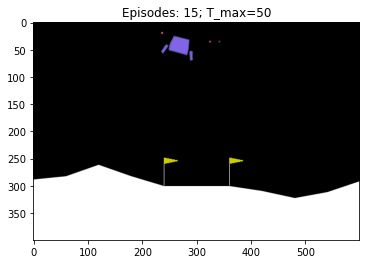

In [9]:
# Disable eager execution (NOTES)
tf.compat.v1.disable_eager_execution

# Create environment
env = gym.make('LunarLander-v2')

# Max no. of episodes and steps:
#n_games = 500
n_games = 15
N_steps_max = 50

# Deep RL hyperparameters:
learn_rate = 0.001
gamma = 0.99
eps_ini = 1.0
eps_dec = 5e-5
eps_min = 0.01
batch_size = 64
mem_size = 100000
model_file_name = 'dqn_attempt_0.00.h5'

# Ini filenames 
# Visualization: gif filename
rec_gif_fname = "LunarLander_test.gif"
# Total scores
scores_fname = "LunarLander_Scores.csv"
# Epsilon
epsilon_hist_fname = "LunarLander_Epsilon.csv"


# Create agent
"""
class DQN_Agent():

    
    # Constructor
                # Environment dimensions and action space params
    def __init__(self, input_dims, discrete_actions, n_actions,  \
                 # RL hyperparameters
                 learn_rate, gamma, epsilon, batch_size, mem_size = 1000000, \
                 # Decrement and lower bound for eps-greedy
                 epsion_dec = 1e-3, epsilon_min =0.01, \
                 # Filename model for saving
                 dqn_fname = 'dqn_model.h5'):    
"""
agent = DQN_Agent(input_dims = env.observation_space.shape, discrete_actions= True, n_actions = env.action_space.n,\
                 learn_rate = learn_rate, gamma=gamma, epsilon=eps_ini, batch_size = batch_size, mem_size = mem_size, \
                 epsilon_dec =eps_dec, epsilon_min =eps_min, dqn_fname = model_file_name)

# Init. score and episode (epsilon) histories
scores_hist = []
eps_hist = []

# Build the DQN (Forgot this on 1st exec...)
agent.build_DQN(256, 256)

# Init. fig. 
fig, ax = plt.subplots()
ims = []
# Init. timer of main loop
dqn_begin_time = datetime.now()

# Loop over episodes:
for i in range(n_games):
    
    # Init. episode
    done = False
    score = 0.0
    s = env.reset()
    # DEBUG: Fix no. of max steps
    N_steps = 0
    # Add a first frame
    img= ax.imshow(env.render('rgb_array'), animated = True)
    ims.append([img])
    
    # Loop over steps in episodes
    while not done and (N_steps < N_steps_max):
        
        # Choose an action
        a = agent.choose_action(s)
        # Get reward and next state
        s_, r, done, info = env.step(a)
        # Update score
        score += r
        # Store transition
        agent.store_transition(s, a, s_, r, done)
        
        # Add frame to ims. Should modify later to keep less frames
        ax.set_title(f"Episodes: {i+1}; T_max={N_steps+1}")
        img= ax.imshow(env.render('rgb_array'), animated = True)
        ims.append([img])
        
        # Learn
        agent.train_dqn(N_steps, i, notify_end_train=True)
        # Update state
        s = s_
        # DEBUG: Increment N_steps
        N_steps += 1
        
    # END while over episode steps
    
    # Update epsilon and score histories
    eps_hist.append(agent.epsilon)
    scores_hist.append(score)

# END OF MAIN DQN LOOP (i over episodes) 

# Exec time of main loop
dqn_exec_time = datetime.now()-dqn_begin_time

# Stop the recording, time the compilation of gif file
dqn_begin_time = datetime.now()
rec = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
env.close()
rec.save(rec_gif_fname)
rec_exec_time = datetime.now()-dqn_begin_time

# Save total scores and epsilon decrease
### NOTE: Modify the code below to clean-out output
df_scores = pd.DataFrame(scores_hist, columns = ['Tot. Score'])
df_scores.to_csv(scores_fname)
df_epsilon = pd.DataFrame(eps_hist, columns = ['Epsilon'])
df_epsilon.to_csv(epsilon_hist_fname)

# Save trained DQN model:
agent.save_dqn()

# Report file open
dqn_begin_time = datetime.now()
report_fname = "Report_LunLand_DQN_"\
                +str(dqn_begin_time.year-2000)+str(dqn_begin_time.month)+str(dqn_begin_time.day)\
                +str(dqn_begin_time.hour)+str(dqn_begin_time.minute)+".txt"
report_file = open(report_fname, mode = "w+")
# Title
report_file.write(f"Deep Q-learning agent - {dqn_begin_time}:\n")
# Write report to file
report_file.write(f"- Execution over {n_games} episodes with {N_steps_max} max. steps completed.\n")
report_file.write(f"- Total training time: {dqn_exec_time}.\n")
report_file.write(f"- GIF recording compilation time: {rec_exec_time} (name: {rec_gif_fname}).\n")
report_file.write(f"- DRL Hypeparameters: * learn_rate = {learn_rate},\n")
report_file.write(f"                      * gamma = {gamma},\n")
report_file.write(f"                      * eps_ini = {eps_ini},\n")
report_file.write(f"                      * eps_dec = {eps_dec},\n")
report_file.write(f"                      * eps_min = {eps_min},\n")
report_file.write(f"                      * batch_size = {batch_size},\n")
report_file.write(f"                      * mem_size = {mem_size},\n")
report_file.write(f"                      * Saved model filename = {model_file_name}.\n")
# Close report file
report_file.close()



C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


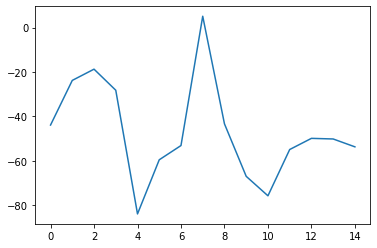

In [10]:
plt.plot(scores_hist)

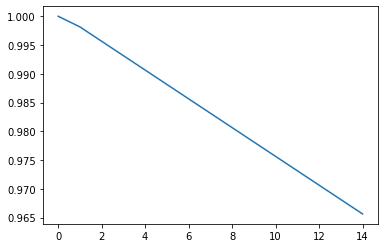

In [11]:
plt.plot(eps_hist)

#### Scrap code for figures

In [56]:
u = np.random.normal(loc = -2, scale = 4, size = 10000)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


(array([1.000e+00, 3.000e+00, 7.000e+00, 2.500e+01, 3.400e+01, 5.700e+01,
        1.000e+02, 2.000e+02, 3.320e+02, 4.420e+02, 5.710e+02, 7.490e+02,
        8.980e+02, 9.160e+02, 1.037e+03, 9.990e+02, 9.890e+02, 7.560e+02,
        6.180e+02, 4.840e+02, 3.140e+02, 2.100e+02, 1.260e+02, 6.900e+01,
        3.500e+01, 1.400e+01, 5.000e+00, 6.000e+00, 1.000e+00, 2.000e+00]),
 array([-17.17729861, -16.13790746, -15.0985163 , -14.05912515,
        -13.019734  , -11.98034284, -10.94095169,  -9.90156053,
         -8.86216938,  -7.82277823,  -6.78338707,  -5.74399592,
         -4.70460476,  -3.66521361,  -2.62582246,  -1.5864313 ,
         -0.54704015,   0.49235101,   1.53174216,   2.57113332,
          3.61052447,   4.64991562,   5.68930678,   6.72869793,
          7.76808909,   8.80748024,   9.84687139,  10.88626255,
         11.9256537 ,  12.96504486,  14.00443601]),
 <BarContainer object of 30 artists>)

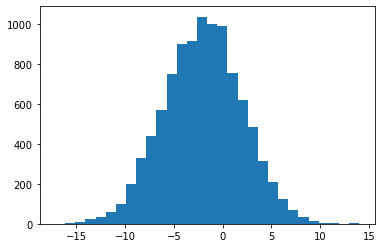

In [58]:
plt.hist(u, bins = 30)

In [60]:
v =  pd.DataFrame(u)
v.to_csv("RANDOM GAUSSIAN NP ARRAY.csv")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:>

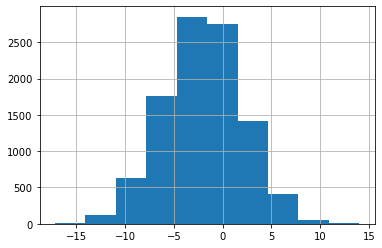

In [82]:
l["Tot. Score"].hist()

In [86]:
del fig_0, axes_1

In [87]:
# Create figure object (Why does the help say it's a function)
fig_0 = plt.figure()



x = np.arange(-1, 1, 0.05)
y = np.sin(x)



<Figure size 432x288 with 0 Axes>

In [88]:
# Add a set of axes
axes_1 = fig_0.add_axes([1,1,1,1])

In [89]:
# Plot the sine function in axes_1
axes_1.plot(x,y)
axes_1.set_xlabel('x')
axes_1.set_ylabel('y')
axes_1.set_title('y=sin(x)', color='b')

Text(0.5, 1.0, 'y=sin(x)')

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


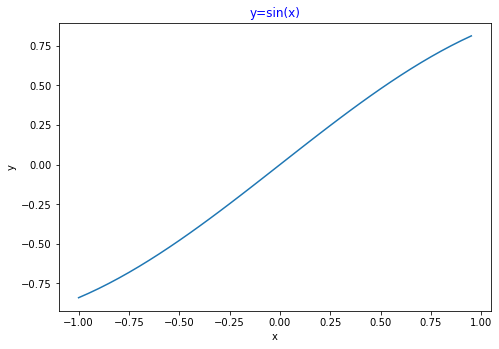

In [90]:
fig_0

In [98]:
fig_0.savefig("TestingTester.jpeg")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [97]:
del test_fig, ax_scores

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel\ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


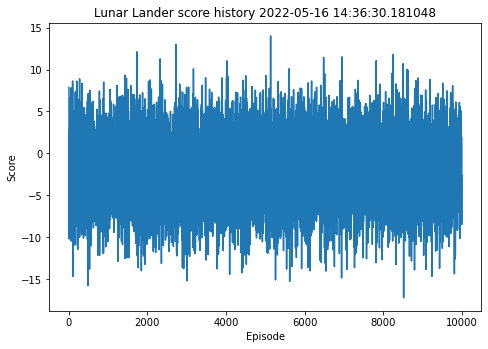

In [96]:
# Instance
test_fig = plt.figure()
# New axis
ax_scores = test_fig.add_axes([1,1,1,1])
x = np.arange(start = 1, stop = len(u)+1, step = 1) # Change end of np.arange(), just episode no.
ax_scores.plot(x, u)
# Typesetting
ax_scores.set_xlabel('Episode')
ax_scores.set_ylabel('Score')
ax_scores.set_title(f'Lunar Lander score history {datetime.now()}') # Change the title's date
# Saving
test_fig.savefig('Score_hist.jpeg',dpi=64)

In [92]:
len(u)

10000